### Для запуска в googlecolab

In [8]:
import os
import zipfile

try:
    from google.colab import drive
    RUNNING_IN_COLAB = True
    
except ImportError:
    drive = None
    RUNNING_IN_COLAB = False

if RUNNING_IN_COLAB:
    os.system('git clone https://github.com/vekshinnikita/face_recognition.git /content/face_recognition')
    os.chdir('/content/face_recognition') 
    
    drive.mount('/content/drive')
    
    zip_dataset_path = '/content/drive/MyDrive/dataset.zip'
    destination_dataset_path = '/content/face_recognition/'
    with zipfile.ZipFile(zip_dataset_path, 'r') as zip_ref:
      zip_ref.extractall(destination_dataset_path)

In [ ]:
from tqdm import tqdm
import os
from typing import Iterable
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from utils.decoder_model import save_model
from torchvision.transforms import v2
from IPython.display import clear_output

from utils.transform import reverse_transform_decorator
from utils.display import show_image_with_bboxes
from utils.decoder_model import calc_metrics, calc_batch_metrics
from utils.iou import iou
from models.simple_decoder_v2 import FaceLocalizationModel, info_string as model_info_string
from dataset_classes.vgg_face2_detector import VGGFace2DetectorDataset

In [10]:
# try:
#     import torch_xla.core.xla_model as xm

#     device = xm.xla_device()
# except ImportError:

#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
device='mps'

In [ ]:
MODE = 'train' # 'train' | 'prod'
PATH_TO_SAVED_FILE = None # Путь к сохраненному файлу с параметрами

SAVE_BEST_DIR_PATH = './best_models/'
SAVE_BEST_FILE_NAME = 'best_simple_decoder_v2_{start_datetime:%m-%d_%H:%M}_epoch_{epoch}.pt'

EPOCHS = 50


In [12]:
SAVE_BEST_FILE_PATH = os.path.join(SAVE_BEST_DIR_PATH, SAVE_BEST_FILE_NAME)

def is_train():
    return MODE == 'train'

def is_load_from_saved():
    return PATH_TO_SAVED_FILE is not None

if is_load_from_saved():
    load_parameters = torch.load(PATH_TO_SAVED_FILE, weights_only=False, map_location=torch.device(device))

In [13]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize((96, 96)),  # Измените размер под вашу модель
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

def reverse_transform(image: torch.Tensor, new_image_size: Iterable):
    new_height, new_width = new_image_size
    
    fn = v2.Compose([
        v2.Normalize(mean=(-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5), std=(1 / 0.5, 1 / 0.5, 1 / 0.5)),
        v2.Resize((new_height, new_width)),  # Возвращаем к исходному размеру
    ])
    
    return fn(image)

if is_train():
    dataset = VGGFace2DetectorDataset(
        './recognition_dataset/images/test',
        './recognition_dataset/labels/test',
        transform,
        reverse_transform
    )
    

# test_data = VGGFace2DetectorDataset(
#     './dataset/images/val',
#     './dataset/labels/test/labels'
# )

In [14]:
if is_train():
    train_set, val_set, test_set = random_split(dataset, [0.7, 0.2, 0.1])

    batch_size = 32

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [15]:
model = FaceLocalizationModel().to(device)

if is_load_from_saved():
    model.load_state_dict(load_parameters['state_model'])


## Проверка модели

Уверенность наличия лица:  0.49, tensor([1.], device='mps:0')
IoU равна: 0.0
tensor([ 48.,  33., 128., 145.]) tensor([1., 0., 0., 0.])


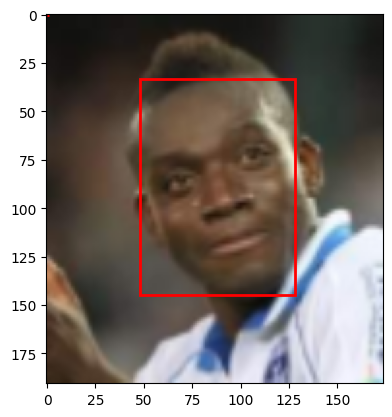

In [16]:
if is_train():
    model.eval()
    image, bbox, confidence, original_image_size = dataset[123]

    reverse_func = reverse_transform_decorator(
        reverse_transform, 
        original_image_size
    )
    
    data = image.unsqueeze(0).to(device) # добавляем нулевую ось, потому что на вход подаются батчи
    bbox = bbox.to(device)
    confidence = confidence.to(device)

    predict_bbox, predict_confidence = model.forward(data)
    predict_bbox = predict_bbox[0]
    predict_confidence = predict_confidence[0]
    
    iou_value = iou(predict_bbox, bbox)
    
    print(f'Уверенность наличия лица: {predict_confidence.item(): .2f}, {confidence}')
    print(f'IoU равна: {iou_value}')

    original_image, predict_bbox = reverse_func(image, predict_bbox)
    original_image, bbox = reverse_func(image, bbox)

    print(bbox, predict_bbox)
    show_image_with_bboxes(original_image, [bbox, predict_bbox])


In [17]:
# Выбор функции потерь

if is_train():
    loss_bbox_model = nn.SmoothL1Loss()
    loss_confidence_model = nn.BCEWithLogitsLoss()
    
    opt = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, # оптимизатор.
        mode= 'min', # 'max' или 'min" - следим, чтобы отслеживаемый параметр увеличивался (*!
        factor=0.1, # коэффициент, на который будет умножен lr
        patience=3, # кол-во.эпох без улучшения отслеживаемого параметра.
    )
    
    if is_load_from_saved():
        ...
        # opt.load_state_dict(load_parameters['state_opt'])
        # lr_scheduler.load_state_dict(load_parameters['state_lr_scheduler'])

In [18]:

if is_train():
    start_from_epoch = 0
    
    train_loss = []
    train_precision = []
    train_recall = []
    train_f1 = []
    train_iou_avg = []
    val_loss = []
    val_recall = []
    val_f1 = []
    val_precision = []
    val_iou_avg = []

    lr_list = []
    best_loss = None
    
    if is_load_from_saved():
        # EPOCHS = load_parameters['epoch']['EPOCHS']
        start_from_epoch = load_parameters['epoch']['save_epoch']
        
        train_loss = load_parameters['loss']['train_loss']
        val_loss = load_parameters['loss']['val_loss']
        # best_loss = load_parameters['loss']['best_loss']
        
        train_precision = load_parameters['metric']['train_precision']
        val_precision = load_parameters['metric']['val_precision']
        train_recall = load_parameters['metric']['train_recall']
        train_f1 = load_parameters['metric']['train_f1']
        val_recall = load_parameters['metric']['val_recall']
        val_f1 = load_parameters['metric']['val_f1']
        train_iou_avg = load_parameters['metric']['train_iou_avg']
        val_iou_avg = load_parameters['metric']['val_iou_avg']
        lr_list = load_parameters['lr_list']
        

In [19]:
start_datetime = datetime.now()

if is_train():
    threshold = 0.1
    saved_epoch = None
    bbox_weight = 2.0
    confidence_weight = 1.0 
    # Цикл обучения
    
    for epoch in range(start_from_epoch, EPOCHS):
        
        # Тренировка модели
        train_loop = tqdm(train_loader, leave=False)
        running_train_loss = []
        
        metrics_var_list = None
        
        model.train()
        for images, target_bbox, target_confidence, _ in train_loop:

            images = images.to(device)
            target_bbox= target_bbox.to(device)
            target_confidence= target_confidence.to(device)
            # Прямой проход + расчет ошибки модели
            pred_bbox, pred_confidence = model(images)
            
            bbox_loss = loss_bbox_model(pred_bbox, target_bbox)
            confidence_loss = loss_confidence_model(pred_confidence, target_confidence)
            
            loss = bbox_loss * bbox_weight + confidence_loss * confidence_weight
            
            # Обратный проход
            opt.zero_grad()
            loss.backward()
            
            # Шаг оптимизации
            opt.step()
            
            running_train_loss.append(loss.item())
            mean_train_loss = sum(running_train_loss)/len(running_train_loss)
            
            var_batch_list = calc_batch_metrics(
                pred_bbox, 
                target_bbox,
                pred_confidence,
                target_confidence,
                iou_threshold=0.7
            )
            if metrics_var_list is None:
                metrics_var_list = var_batch_list.detach().numpy()
            else:
                metrics_var_list += var_batch_list.detach().numpy()
            
            train_loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss: .4f}")
            
            # Расчет значения метрики  
            # Сохранение значения функции потерь и метрики
    
        
        r_train_precision, r_train_recall, r_train_f1, r_train_iou_avg = calc_metrics(*metrics_var_list)
        train_loss.append(mean_train_loss)
        train_precision.append(r_train_precision)
        train_recall.append(r_train_recall)
        train_f1.append(r_train_f1)
        train_iou_avg.append(r_train_iou_avg)
        
        # Проверка модели (валидация)
        running_val_loss = []
        metrics_var_list = None
        
        model.eval()
        with torch.no_grad():
            for images, target_bbox, target_confidence, _ in val_loader:
                
                images = images.to(device)
                target_bbox= target_bbox.to(device)
                target_confidence= target_confidence.to(device)
                # Прямой проход + расчет ошибки модели
                pred_bbox, pred_confidence = model(images)
                
                bbox_loss = loss_bbox_model(pred_bbox, target_bbox)
                confidence_loss = loss_confidence_model(pred_confidence, target_confidence)

                loss = bbox_loss * bbox_weight + confidence_loss * confidence_weight
                
                running_val_loss.append(loss.item())
                mean_val_loss = sum(running_val_loss)/len(running_val_loss)
                
                var_batch_list = calc_batch_metrics(
                    pred_bbox, 
                    target_bbox,
                    pred_confidence,
                    target_confidence,
                    iou_threshold=0.7
                )
                if metrics_var_list is None:
                    metrics_var_list = var_batch_list.detach().numpy()
                else:
                    metrics_var_list += var_batch_list.detach().numpy()
                    
            r_val_precision, r_val_recall, r_val_f1, r_val_iou_avg = calc_metrics(*metrics_var_list)
            
            val_loss.append(mean_val_loss)
            val_precision.append(r_val_precision)
            val_recall.append(r_val_recall)
            val_f1.append(r_val_f1)
            val_iou_avg.append(r_val_iou_avg)
                
            # Расчет значения метрики
            # Сохранение значения функции потерь и метрики
        
        lr_scheduler.step(mean_val_loss)
        lr = lr_scheduler.get_last_lr()
        lr_list.append(lr)
        
        if best_loss is None:
            best_loss = mean_val_loss
        
        if mean_val_loss < best_loss - best_loss * threshold:
            best_loss = mean_val_loss
            
            # if saved_epoch is not None:
            #     prefix = SAVE_BEST_FILE_NAME.split('{start_datetime:%m-%d_%H:%M}')[0] + '{start_datetime:%m-%d_%H:%M}'
            #     delete_files_with_prefix(
            #         SAVE_BEST_DIR_PATH,
            #         prefix.format(start_datetime=start_datetime)
            #     )
            
            saved_epoch = epoch+1
            save_model(
                file_path=SAVE_BEST_FILE_PATH,
                str_info=model_info_string,
                model=model,
                start_datetime=start_datetime,
                opt=opt,
                lr_scheduler=lr_scheduler,
                train_loss=train_loss,
                val_loss=val_loss,
                best_loss=best_loss,
                train_precision=train_precision,
                train_iou_avg=train_iou_avg,
                train_recall=train_recall,
                train_f1=train_f1,
                val_recall=val_recall,
                val_f1=val_f1,
                val_iou_avg=val_iou_avg,
                val_precision=val_precision,
                lr_list=lr_list,
                EPOCHS=EPOCHS,
                epoch=epoch+1,
            )
            print(f'Ha эпoxe - {epoch+1}, сохранена модель со значением функции потерь на валидации - {mean_val_loss: 4f}', end='\n\n')

        print(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss: .4f}, train_precision={r_train_precision: .4f}, train_recall={r_train_recall: .4f}, train_f1={r_train_f1: .4f}, train_iou_avg={r_train_iou_avg: .4f}, val_loss={mean_val_loss: .4f}, val_precision={r_val_precision: .4f}, val_recall={r_val_recall: .4f}, val_f1={r_val_f1: .4f}, val_iou_avg={r_val_iou_avg: .4f}, lr={lr}")

KeyboardInterrupt: 

In [ ]:
if is_train():
    plt.plot(lr_list)
    plt.show()

In [ ]:
if is_train():
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(['loss_train', 'loss_val'])
    plt.show()

In [ ]:
if is_train():
    plt.plot(train_precision)
    plt.plot(val_precision)
    plt.legend(['train_precision', 'val_precision'])
    plt.show()

In [ ]:
if is_train():
    image, bbox, confidence, original_image_size = dataset[405]

    reverse_func = reverse_transform_decorator(
        reverse_transform, 
        original_image_size
    )

    data = image.unsqueeze(0).to(device) # добавляем нулевую ось, потому что на вход подаются батчи

    predict_bbox = model.forward(data)[0]

    original_image, predict_bbox = reverse_func(image, predict_bbox)
    original_image, bbox = reverse_func(image, bbox)

    show_image_with_bboxes(original_image, [predict_bbox])

In [ ]:
from calendar import c
import cv2
import time
from PIL import Image

from utils.transform import transform_bbox

# 2.  Захват видео с веб-камеры
cap = cv2.VideoCapture(0)  # 0 - индекс веб-камеры по умолчанию. Измените, если у вас несколько камер.

# Проверка, успешно ли открыта веб-камера
if not cap.isOpened():
    raise IOError("Не удается открыть веб-камеру")


frame_count = 0
start_time = time.time()
fps = 0
cx1 = 300  # Координата x верхнего левого угла
cy1 = 0   # Координата y верхнего левого угла
width = 700  # Ширина обрезанной области
height = 700 # Высота обрезанной области

model.eval()
# 3. Основной цикл обработки кадров
while(True):
    # Считываем кадр с веб-камеры
    ret, frame = cap.read()

    # Если кадр не был успешно считан, выходим из цикла
    if not ret:
        break
    
    # # Получаем высоту и ширину кадра
    frame_height, frame_width, channels = frame.shape

    # Проверка, что координаты обрезки находятся в пределах кадра
    if cx1 >= 0 and cy1 >= 0 and cx1 + width <= frame_width and cy1 + height <= frame_height:
        # Обрезаем кадр
        frame = frame[cy1:cy1 + height, cx1:cx1 + width]

    else:
        print("Ошибка: Координаты обрезки выходят за пределы кадра.")
        
    
    
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)
    
    
    input_tensor = transform(pil_image)
    input_tensor = input_tensor.unsqueeze(0)  # Добавьте размерность батча
    input_tensor = input_tensor.to(device)
    
    with torch.no_grad():  # Отключите вычисление градиентов во время инференса
        pred_bbox, pred_confidence = model(input_tensor)
    
    # reverse_func = reverse_transform_decorator(
    #     reverse_transform, 
    #     (1200,720)
    # )
    # original_image, predict_bbox = reverse_func(input_tensor[0], pred_bbox[0])
    

    
    
    for bbox, confidence in zip(pred_bbox, pred_confidence):
        bbox = transform_bbox(bbox, input_tensor.shape[2:] ,pil_image.size[::-1])
        x1 = int(bbox[0])
        y1 = int(bbox[1])
        x2 = int(bbox[2])
        y2 = int(bbox[3])
        
        confidence = confidence.item()

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f"{confidence:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    frame_count += 1
    elapsed_time = time.time() - start_time

    if elapsed_time > 1:  # Обновляем FPS каждую секунду
        fps = frame_count / elapsed_time
        start_time = time.time()
        frame_count = 0

    # Добавим FPS на кадр для отображения на экране
    cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # 7. Отображение результата
    cv2.imshow('Обнаружение лиц', frame)

    # 8. Выход из цикла при нажатии клавиши 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    

# 9. Освобождение ресурсов
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

: 